# Donation Analysis

Wellcome to this Jupyter Notebook. Below you will see code that will perform some

- Exploratory Analysis
- Data Visualisation

on some (fake) donation data. Important - as data is made up it is quite weird.

We were going to do an example of network analysis but decided against it as it uses additional tools outside of jupyter notebook.

You can run each cell by selecting it and clicking run in the toolbar above. Cells sometimes need to be run in order.

Below is a cell where the data is imported and then manipulated into a Pandas Dataframe from which we can do some analysis.

In [38]:
import pandas as pd

donor_data = pd.read_csv("donor_data.csv")

ids = []
dates = []
types = []
events = []
amounts = []
quarters = [] # new feature created for association analysis

def which_quarter(x):
    if x <= 91:
        return 1
    elif 91 < x and x <= 182:
        return 2
    elif 182 < x and x <= 273:
        return 3
    else:
        return 4

for key, value in donor_data.iterrows():
    donation = value[0]
    
    donor_id = donation.split("[")[0].replace(" ", "")
    date = donation.split("[")[1].split(",")[0].replace(" ", "")
    donation_type = donation.split("[")[1].split(",")[1].replace(" ", "")
    event = donation.split("[")[1].split(",")[2][1:].replace(" ", "")
    amount = donation.split("[")[1].split(",")[3][:-1].replace(" ", "")
    quarter = which_quarter(int(date))
    
    ids.append(donor_id)
    dates.append(date)
    types.append(donation_type)
    events.append(event)
    amounts.append(amount)
    quarters.append(quarter)
    
donor_data = pd.DataFrame({"id" : ids, "date" : dates, "type" : types,
                           "event" : events, "amount" : amounts,
                           "quarter" : quarters})

donor_data[["id", "date", "amount"]] = donor_data[["id", "date", "amount"]].apply(pd.to_numeric)
donor_data.set_index("id", inplace=True)

donor_data.head()
    

,date,type,event,amount,quarter
id,,,,,
58,179,Single,B10K,13,2
19,131,Repeated,N,5,2
20,165,Repeated,B10K,15,2
35,340,Single,B10K,2,4
37,263,Single,B10K,2,3


## Exploratory Analysis

We'll take each variable and see what we can find.

### Date
To simplify things the dates run from 1 to 365 representing the days in a normal calendar year. Let's have a look at donation frequency.

Text(0.5, 1.0, 'Donation Frequency Histogram')

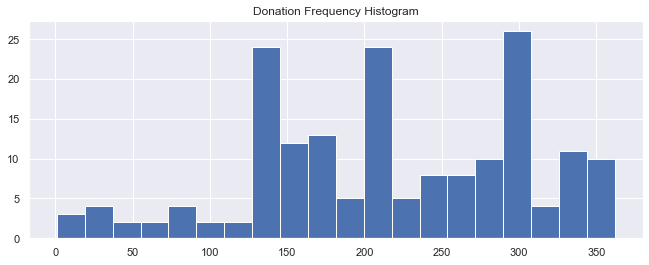

In [39]:
import seaborn as sns

# change figure size
sns.set(rc={'figure.figsize':(11, 4)})

donor_data["date"].hist(bins=20).set_title("Donation Frequency Histogram")

Things to note:

- slow start to the year
- peak number of donations around 140 days, 200 days, 300 days

Later we'll look at events to see if that can explain the patterns we see here.

Next let's look at the amounts data.

### Amounts

Text(0.5, 1.0, 'Amounts Histogram (Legacy Donations and >= 50 Removed)')

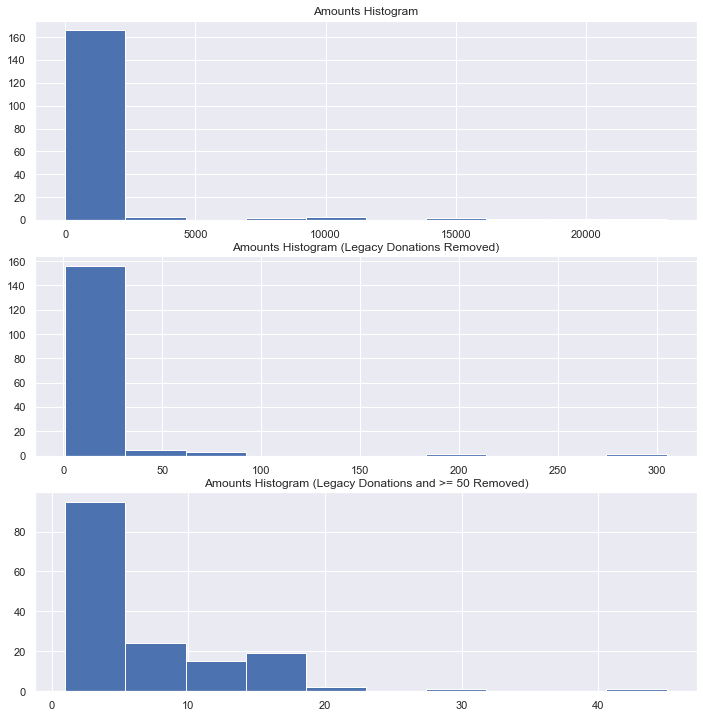

In [28]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(10, 10))

fig.tight_layout()

donor_data["amount"].hist(ax=axs[0])

donor_data[donor_data["type"] != "Legacy"]["amount"].hist(ax=axs[1])

donor_data[(donor_data["type"] != "Legacy") &
           (donor_data["amount"] < 50)]["amount"].hist(ax=axs[2])

axs[0].set_title("Amounts Histogram")
axs[1].set_title("Amounts Histogram (Legacy Donations Removed)")
axs[2].set_title("Amounts Histogram (Legacy Donations and >= 50 Removed)")



### Events

First let's find out what events there are and when they occur.

In [2]:
donor_data["event"].unique()

NameError: name 'donor_data' is not defined

These correspond respectively to Bristol 10k, No event, Christmas Meal and Summer Fete

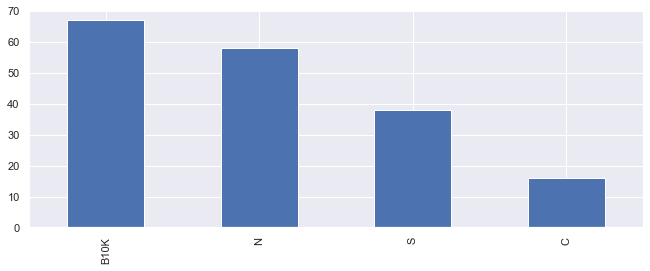

In [7]:
donor_data["event"].value_counts().plot(kind='bar')

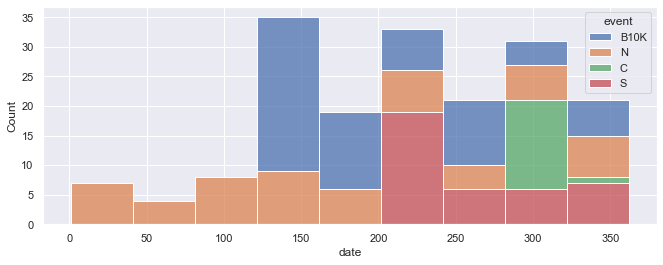

In [4]:
sns.histplot(donor_data, x="date", hue="event", multiple="stack")

### Type

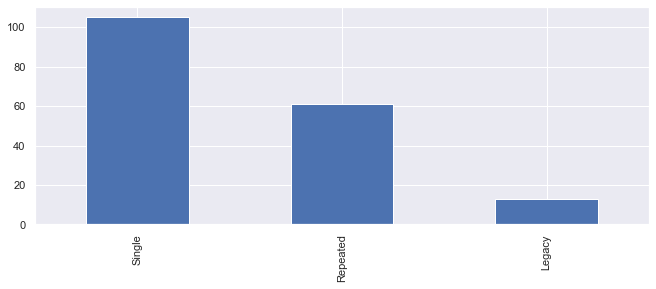

In [30]:
donor_data["type"].value_counts().plot(kind='bar')

Repeated donations are good. We want to find associations between features and repeated donations.

In [35]:
from scipy.stats import chi2_contingency

explanatory_features = ["quarter", "event"] # could also include amount buckets

for feature in explanatory_features:
    obs = pd.crosstab(donor_data["type"], donor_data[feature])
    print("---------  ", feature, "  -------------")
    print(chi2_contingency(obs))

---------   quarter   -------------
(6.872968106421124, 0.33275507047433134, 6, array([[ 1.08938547,  3.84916201,  3.77653631,  4.2849162 ],
       [ 5.11173184, 18.06145251, 17.72067039, 20.10614525],
       [ 8.79888268, 31.08938547, 30.5027933 , 34.60893855]]))
---------   event   -------------
(58.40582516910013, 9.481557679345336e-11, 6, array([[ 4.86592179,  1.16201117,  4.2122905 ,  2.75977654],
       [22.83240223,  5.45251397, 19.76536313, 12.94972067],
       [39.30167598,  9.38547486, 34.02234637, 22.29050279]]))


In [36]:
pd.crosstab(donor_data["type"], donor_data["event"])

event,B10K,C,N,S
type,,,,
Legacy,1,6,4,2
Repeated,8,3,28,22
Single,58,7,26,14
